# Hands on Guide to Twitter Sentiment Analysis with dataset and code

## Introduction

Natural Language Processing (NLP) is a hotbed of research in data science these days and one of the most common applications of NLP is sentiment analysis. From opinion polls to creating entire marketing strategies, this domain has completely reshaped the way businesses work, which is why this is an area every data scientist must be familiar with.
<br>
<br>
Thousands of text documents can be processed for sentiment (and other features including named entities, topics, themes, etc.) in seconds, compared to the hours it would take a team of people to manually complete the same task.

<br>
<br>
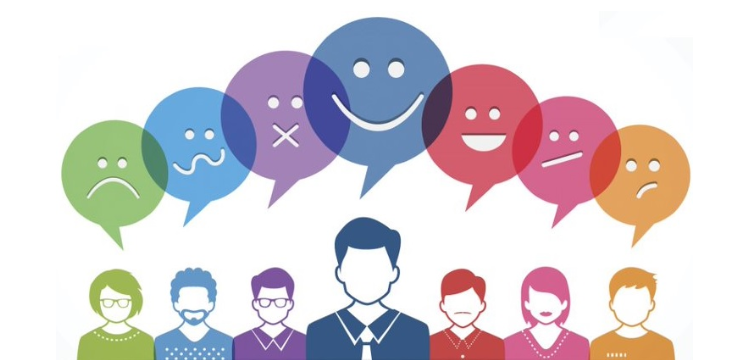
<br>
<br>
In this notebook, we will learn how to solve the Twitter Sentiment Analysis Practice Problem.

We will do so by following a sequence of steps needed to solve a general sentiment analysis problem. We will start with preprocessing and cleaning of the raw text of the tweets. Then we will explore the cleaned text and try to get some intuition about the context of the tweets. After that, we will extract numerical features from the data and finally use these feature sets to train models and identify the sentiments of the tweets.

This is one of the most interesting challenges in NLP so I’m very excited to take this journey with you!

### Table of Contents
* **Understand the Problem Statement
* **Tweets Preprocessing and Cleaning**
* **Story Generation and Visualization from Tweets**
* **Extracting Features from Cleaned Tweets**
* **Model Building: Sentiment Analysis**
* **What’s Next**
<br>
<br>
## 1. Understand the Problem Statement

Let’s go through the problem statement once as it is very crucial to understand the objective before working on the dataset. The problem statement is as follows:

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

Note: The evaluation metric from this practice problem is **F1-Score**.

Personally, I quite like this task because hate speech, trolling and social media bullying have become serious issues these days and a system that is able to detect such texts would surely be of great use in making the internet and social media a better and bully-free place. Let’s look at each step in detail now.

## 2. Tweets Preprocessing and Cleaning
Take a look at the pictures below depicting two scenarios of an office space – one is untidy and the other is clean and organized. 

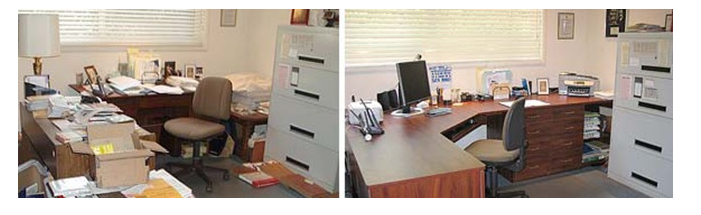

You are searching for a document in this office space. In which scenario are you more likely to find the document easily? Of course, in the less cluttered one because each item is kept in its proper place. The data cleaning exercise is quite similar. If the data is arranged in a structured format then it becomes easier to find the right information.
<br><br>
The preprocessing of the text data is an essential step as it makes the raw text ready for mining, i.e., it becomes easier to extract information from the text and apply machine learning algorithms to it. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.
<br><br>
In one of the later stages, we will be extracting numeric features from our Twitter text data. This feature space is created using all the unique words present in the entire data. So, if we preprocess our data well, then we would be able to get a better quality feature space.
<br><br>
Let’s first read our data and load the necessary libraries. You can download the datasets from here.

In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

Let’s check the first few rows of the train dataset.

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


The data has 3 columns id, label, and tweet. label is the binary target variable and tweet contains the tweets that we will clean and preprocess.
<br><br>
Initial data cleaning requirements that we can think of after looking at the top 5 records:
<br><br>
* The Twitter handles are already masked as @user due to privacy concerns. So, these Twitter handles are hardly giving any information about the nature of the tweet.<br>
* We can also think of getting rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different kinds of tweets.<br>
* Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.<br>
* Once we have executed the above three steps, we can split every tweet into individual words or tokens which is an essential step in any NLP task.<br>
* In the 4th tweet, there is a word ‘love’. We might also have terms like loves, loving, lovable, etc. in the rest of the data. These terms are often used in the same context. If we can reduce them to their root word, which is ‘love’, then we can reduce the total number of unique words in our data without losing a significant amount of information.
 
<br>
# A) Removing Twitter Handles (@user)
As mentioned above, the tweets contain lots of twitter handles (@user), that is how a Twitter user acknowledged on Twitter. We will remove all these twitter handles from the data as they don’t convey much information.
<br><br>
For our convenience, let’s first combine train and test set. This saves the trouble of performing the same steps twice on test and train.

In [4]:
combi = train.append(test, ignore_index=True)

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Given below is a user-defined function to remove unwanted text patterns from the tweets. It takes two arguments, one is the original string of text and the other is the pattern of text that we want to remove from the string. The function returns the same input string but without the given pattern. We will use this function to remove the pattern ‘@user’ from all the tweets in our data.

In [5]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

Now let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed “@[\w]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [6]:
# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

# B) Removing Punctuations, Numbers, and Special Characters
As discussed, punctuations, numbers and special characters do not help much. It is better to remove them from the text just as we removed the twitter handles. Here we will replace everything except characters and terms starting with # (twitter trends).

In [7]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# C) Removing Short Words
We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [8]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

Let’s take another look at the first few rows of the combined dataframe.

In [9]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

# D) Tokenization
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [10]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

# E) Stemming
Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

In [11]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

# 3. Story Generation and Visualization from Tweets
In this section, we will explore the cleaned tweets text. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights. Here explore the hashtags and the most frequent words in the data. Do not limit yourself to only these methods, feel free to explore the data as much as possible.
<br>
Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:
<br>
* What are the most common words in the entire dataset?
* What are the most common words in the dataset for negative and positive tweets, respectively?
* How many hashtags are there in a tweet?
* Which trends are associated with my dataset?
* Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

# A) Understanding the common words used in the tweets: WordCloud
Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.
<br><br>
A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.
<br><br>
Let’s visualize all the words our data using the wordcloud plot.<br>

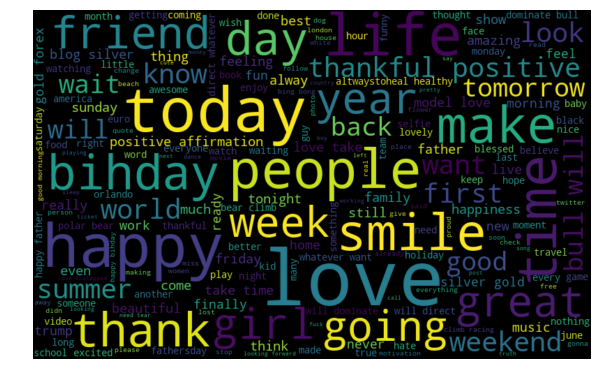

In [12]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy and love being the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes(racist/sexist or not) in our train data.

# B) Words in non racist/sexist tweets

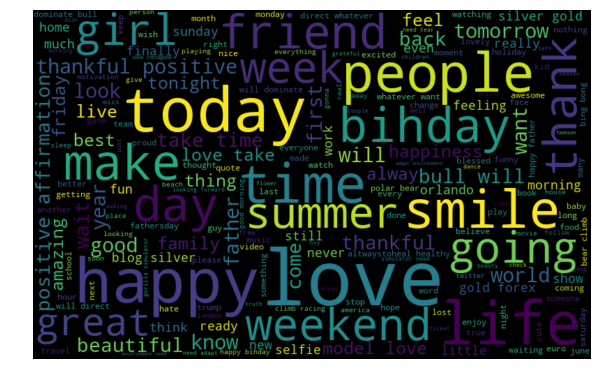

In [13]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy, smile, and love being the most frequent ones. Hence, most of the frequent words are compatible with the sentiment which is non racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

# C) Racist/Sexist Tweets

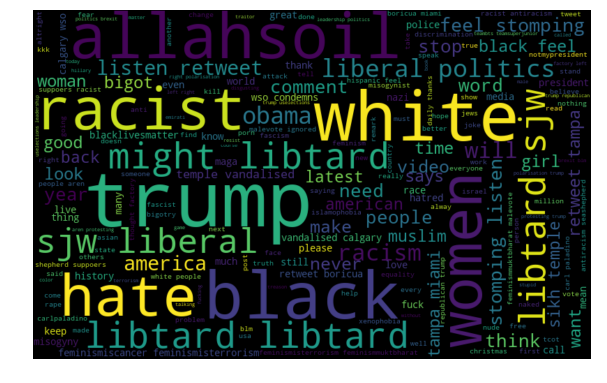

In [14]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

# D) Understanding the impact of Hashtags on tweets sentiment
Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.
<br>
For instance, given below is a tweet from our dataset: 
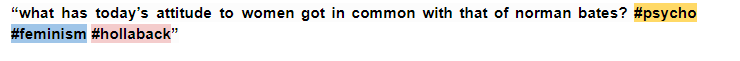
<br>
The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.
<br><br>
We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [15]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [16]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top n hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

# Non-Racist/Sexist Tweets

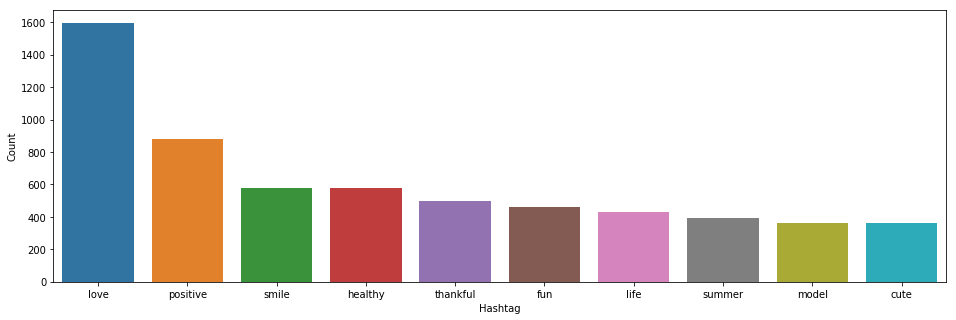

In [17]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

# Racist/Sexist Tweets

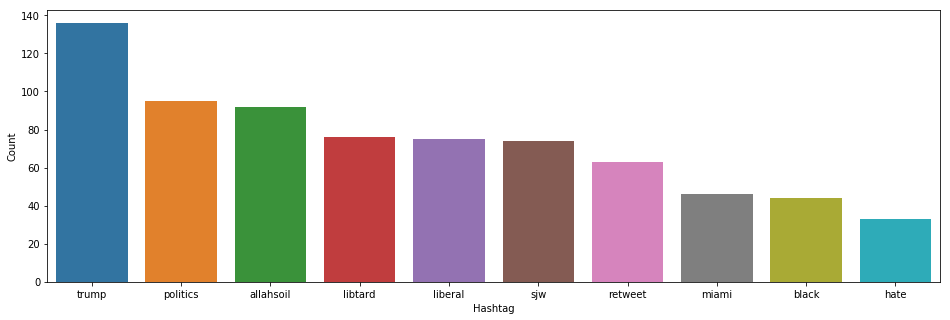

In [18]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

# 4. Extracting Features from Cleaned Tweets
To analyze a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag-of-Words, TF-IDF, and Word Embeddings. In this article, we will be covering only Bag-of-Words and TF-IDF.
<br>
 

## Bag-of-Words Features
<br>Bag-of-Words is a method to represent text into numerical features. Consider a corpus (a collection of texts) called C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a list, and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).
<br><br>
Let us understand this using a simple example. Suppose we have only 2 document
<br><br>
D1: He is a lazy boy. She is also lazy.
<br><br>
D2: Smith is a lazy person.
<br><br>
The list created would consist of all the unique tokens in the corpus C.
<br><br>
= [‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]
<br><br>
Here, D=2, N=6
<br><br>
The matrix M of size 2 X 6 will be represented as –
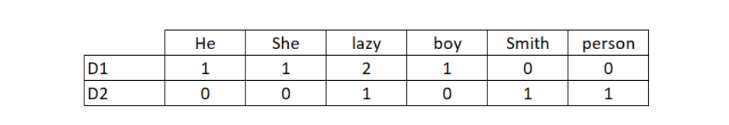

Now the columns in the above matrix can be used as features to build a classification model. Bag-of-Words features can be easily created using sklearn’s CountVectorizer function. We will set the parameter max_features = 1000 to select only top 1000 terms ordered by term frequency across the corpus.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

# TF-IDF Features
This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.
<br><br>
TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.
<br>
Let’s have a look at the important terms related to TF-IDF:
<br>
* TF = (Number of times term t appears in a document)/(Number of terms in the document)
* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
* TF-IDF = TF*IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

# 5. Model Building: Sentiment Analysis
We are now done with all the pre-modeling stages required to get the data in the proper form and shape. Now we will be building predictive models on the dataset using the two feature set — Bag-of-Words and TF-IDF.
<br><br>
We will use logistic regression to build the models. It predicts the probability of occurrence of an event by fitting data to a logit function.
<br>
The following equation is used in Logistic Regression:
<br>
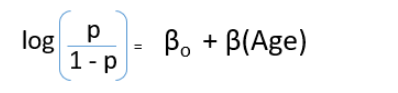


# A) Building model using Bag-of-Words features

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5017421602787456

We trained the logistic regression model on the Bag-of-Words features and it gave us an F1-score of 0.525 for the validation set. Now we will use this model to predict for the test data.

In [22]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

The public leaderboard F1 score is 0.537. Now we will again train a logistic regression model but this time on the TF-IDF features. Let’s see how it performs.

 

# B) Building model using TF-IDF features

In [23]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5091240875912408

The public leaderboard F1 score is 0.541. So, both validation score and public leaderboard score have improved in the case of TF-IDF feature space.

 